In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from spicy_snow.retrieval import retrieval_from_parameters

In [3]:
data_fp = Path('/bsuhome/zacharykeskinen/scratch/spicy/SnowEx-Data-params/')
ds = xr.open_dataset(next(data_fp.glob('*Banner*2021*.nc')))

In [7]:
snotel = pd.read_csv('/bsuhome/zacharykeskinen/spicy-analysis/results/312_STAND_WATERYEAR=2021.csv', skiprows = 4, parse_dates = ['Date'])
snotel['sd'] = snotel['SNWD.I-1 (in) ']* 0.0254
snotel = snotel.set_index('Date')
snotel = snotel.loc[slice(pd.to_datetime(ds.time.min().data), pd.to_datetime(ds.time.max().data))]

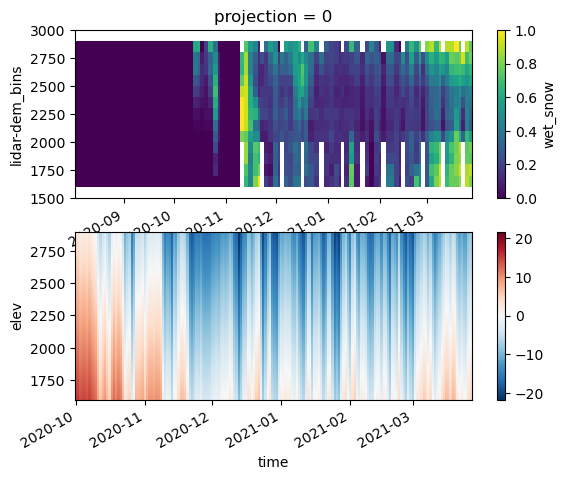

In [62]:
ds = retrieval_from_parameters(ds, A = 2.5, B =  0.2, C= 0.55, freezing_snow_thresh = 0.5, wet_SI_thresh = 0)

x_bins = np.arange(1500, 3100, 100)

wet_elev = ds[['wet_snow', 'lidar-dem']].groupby_bins('lidar-dem', x_bins).mean(skipna = True)['wet_snow']


In [56]:
temps = snotel['TAVG.D-1 (degC) '].values.reshape((1, -1))

# temps = xr.DataArray(temps,
#     coords = [[2150], snotel.index],
#     dims = ['dem_bins', 'time'])

lapse_rate = 9.8/1000 # deg C per m

elev_range = range(1600, 2900)
lapse_ts = xr.DataArray(np.zeros((len(range(1600, 2900)), len(snotel.index))),
    coords = [elev_range, snotel.index],
    dims = ['elev', 'time'])

for elev in elev_range:
    lapse_t = snotel['TAVG.D-1 (degC) '].values + (2150 - elev) * lapse_rate
    lapse_ts.loc[dict(elev = elev)] = lapse_t.ravel()

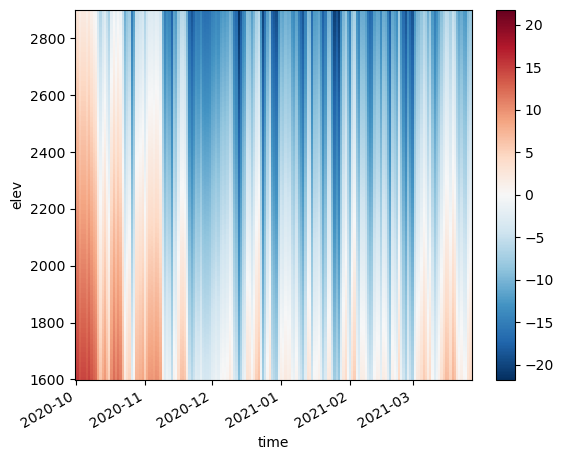

In [58]:
lapse_ts.plot()

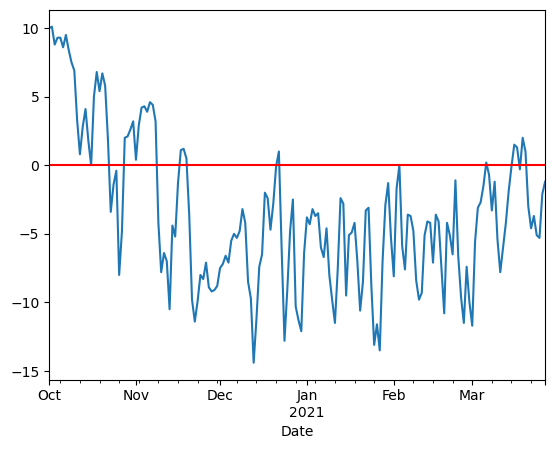

In [16]:
ax = snotel['TAVG.D-1 (degC) '].plot()
ax.axhline(0, color = 'red')

(18536.830688657406, 18713.332939814816)

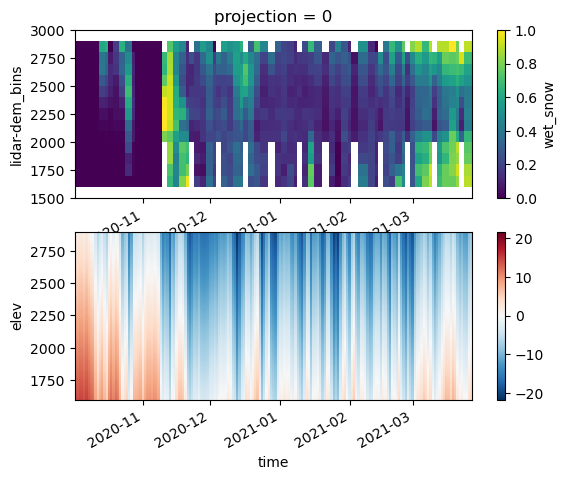

In [72]:
fig, axes = plt.subplots(2, 1)

wet_elev.sel(time = slice(lapse_ts.time[0], lapse_ts.time[-1])).plot(ax = axes[0]) #.where(ds.relative_orbit == ds.relative_orbit[1], drop = True)
# plt.gca().axhline(2145.792, color = 'white')
lapse_ts.plot(ax = axes[1])
axes[1].set_xlim(axes[0].get_xlim())